# Model - Pulls

In [1]:
import ast
import datetime
import dateutil.parser
import distutils.dir_util
import glob
import IPython.display
import json
import math
import numpy as np
import os
import pandas as pd
import pathlib
import pickle
import pyautogui
import pytz
import re
import requests
import selenium
import shutil
import statsapi
import statsmodels.formula.api as smf
import time
import unidecode
import warnings
import webbrowser
import xlrd
import random
import urllib
from urllib.request import urlopen, Request
import zipfile

from bs4 import BeautifulSoup
from datetime import date
from IPython.display import display, Javascript
from joblib import Parallel, delayed
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium import webdriver
from openpyxl import load_workbook
from functools import partial

from statsapi import get
from pydfs_lineup_optimizer import get_optimizer, Site, Sport, Player, TeamStack, PlayerFilter, RandomFantasyPointsStrategy

os.chdir(r"C:\Users\james\Documents\MLB\Code")

# from Utilities import *
# from Classes import *
# from simulation_functions_three import *

import smtplib
import ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders

# Ensure the warning is ignored only once
warnings.simplefilter(action="ignore")

# Display the DataFrame
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# Set paths
model_path = r"C:\Users\james\Documents\MLB\Code\Models"
baseball_path = r"C:\Users\james\Documents\MLB\Data2"
download_path = r"C:\Users\james\Downloads"

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

import joblib

In [3]:
%run "Utilities.ipynb"

In [4]:
# This reads in Chadwick register with player codes.
keep_list = ['key_mlbam', 'key_fangraphs', 'key_bbref_minors', 'key_bbref', 'name_first', 'name_last']
chadwick = read_chadwick(keep_list)

In [5]:
# Today's Date
# YYYY-MM-DD (datetime)
todaysdate_dt = datetime.date.today()

# YYYY-MM-DD (string)
todaysdate_dash = str(todaysdate_dt)

# MM/DD/YYYY
todaysdate_slash = todaysdate_dash.split("-")
todaysdate_slash = todaysdate_slash[1] + "/" + todaysdate_slash[2] + "/" + todaysdate_slash[0]

# YYYYMMDD
todaysdate = todaysdate_dash.replace("-", "")

## MM-DD-YYYY
todaysdate_dash = todaysdate[:4] + "-" + todaysdate[4:6] + "-" + todaysdate[6:]

In [6]:
# Note: Not entirely sure if pulls are before or after PA in my model - check that they align

In [7]:
%run "4. Dataset.ipynb"

Code was last run on: 2023-08-17


In [8]:
df = import_data(2019, 2023)
sample = create_datasets(df, "20230806")

In [9]:
def pull_dataset(sample): 
    # Calculate scores bot batter and pitcher teams
    sample['pitcher_score'] = np.where(sample['halfInning'] == "top", sample['homeScore'], sample['awayScore'])
    sample['batter_score'] = np.where(sample['halfInning'] == "top", sample['awayScore'], sample['homeScore'])
    
    sample['faced'] = 1
    
    # Cumulative counts
    # Stats to sum
    events_list = list(sample['eventsModel'].unique())
    sums_list = events_list + ['rbi', 'faced', 'gamePk', 'pitcher']
    # Calculate
    sums = sample[sums_list].groupby(['gamePk', 'pitcher']).cumsum()
    # Add suffix
    sums = sums.add_suffix("_sum")
    
    # Add rolling sums
    sample = pd.concat([sample, sums], axis=1)

    # Fill in missings
    sample['avgFaced'].fillna(6, inplace=True)
    sample['starts'].fillna(0, inplace=True)
    
    # Identify starter throughout
    sample['starter'] = sample.groupby(['pitcher', 'gamePk'])['start'].cumsum()
    
    # Keep only starters
    sample = sample.query('starter == 1')
    
    
    return sample

sample2 = pull_dataset(sample)

### Create Models

In [10]:
# Inputs
X_list = ['b1_sum', 'b2_sum', 'b3_sum', 'bb_sum', 'hbp_sum',
          'hr_sum', 'so_sum', 'faced_sum', 'rbi_sum', 'pitcher_score', 'batter_score',
          'inning', 'outs', 'starts', 'avgFaced']

In [11]:
# Full dataset
X = sample2[X_list]
y = sample2['pulled']

# # Split into training and test data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Split into training and testing groups
X_train = sample2.groupby(sample2['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_test = sample2.groupby(sample2['year']).apply(lambda x: x.tail(int(len(x)*1/3)))

In [13]:
# Train Model
# model = MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', random_state=1,max_iter=200).fit(X_train[X_list], X_train['pulled'])
# model = LogisticRegression(solver='saga', max_iter=200).fit(X_train[X_list], X_train['pulled'])

models = [
    LogisticRegression(solver='lbfgs', max_iter=200),  
    LogisticRegression(solver='saga', max_iter=200),   
    MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', random_state=1, max_iter=20),  
]

model = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train[X_list], X_train['pulled'])


# Predict probability of pull
preds = model.predict_proba(X_test[X_list])

# Create dataframe
preds_df = pd.DataFrame(preds)

# Save 
os.chdir(model_path)
filename = "nn_pull_voting.sav"
pickle.dump(model, open(filename, 'wb'))

In [14]:
# Create test dataframe with projections
X_test2 = X_test.reset_index(drop=True)
y_test2 = X_test2['pulled']
X_test2 = X_test2[X_list]

test_df = pd.concat([X_test2, y_test2, preds_df], axis=1)

test_df.rename(columns={0: "Keep", 1: "Pull"}, inplace=True)

test_df.head()

,b1_sum,b2_sum,b3_sum,bb_sum,hbp_sum,hr_sum,so_sum,faced_sum,rbi_sum,pitcher_score,batter_score,inning,outs,starts,avgFaced,pulled,Keep,Pull
0,0,0,1,0,0,2,6,12,2,1,2,4,0,14.0,14.466667,0,0.996471,0.003529
1,0,0,1,0,0,3,6,13,4,1,4,4,0,14.0,14.466667,0,0.991832,0.008168
2,0,0,1,0,0,3,6,14,4,1,4,4,1,14.0,14.466667,0,0.983733,0.016267
3,0,0,1,0,0,3,6,15,4,1,4,4,2,14.0,14.466667,0,0.957987,0.042013
4,0,0,1,0,0,4,6,16,5,1,5,4,2,14.0,14.466667,0,0.939186,0.060814


In [15]:
# Split into two samples based on pitcher's starting experience
short = test_df.query('starts < 30')
long = test_df.query('starts >= 30')

##### Main

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


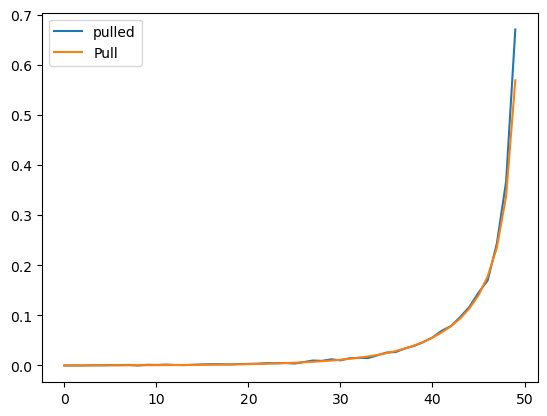

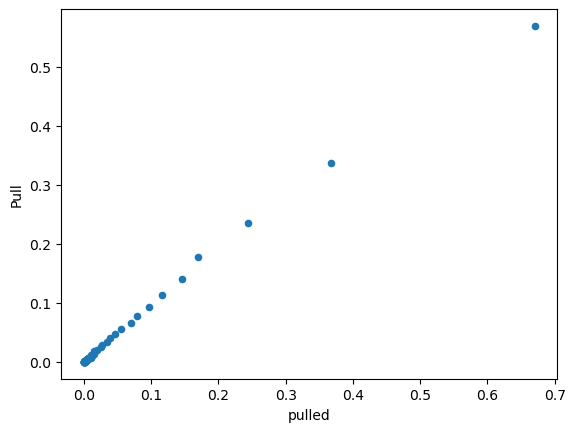

In [27]:
# Graph
test_df['decile'] = pd.qcut(test_df['Pull'], 50, labels=False)
graph = test_df.groupby('decile').mean().reset_index()

print(graph[['pulled', 'Pull']].plot.line())
print(graph.plot.scatter('pulled', 'Pull'))

##### Short Sample

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


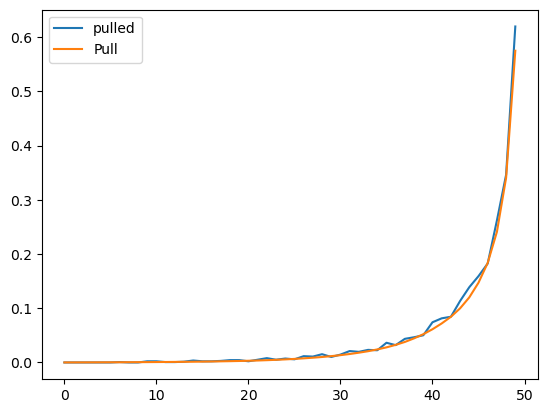

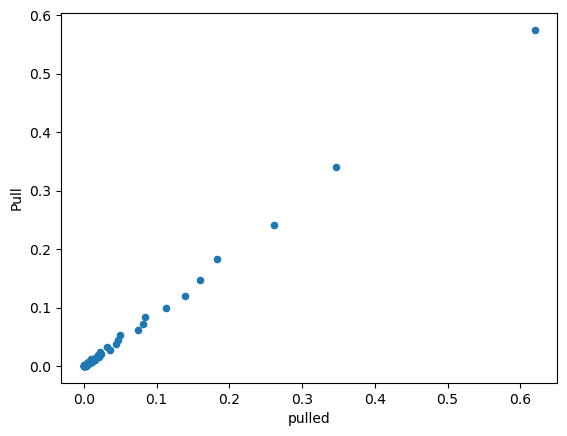

In [26]:
# Graph
short['decile'] = pd.qcut(short['Pull'], 50, labels=False)
short_graph = short.groupby('decile').mean().reset_index()

print(short_graph[['pulled', 'Pull']].plot.line())
print(short_graph.plot.scatter('pulled', 'Pull'))

##### Long Sample 

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


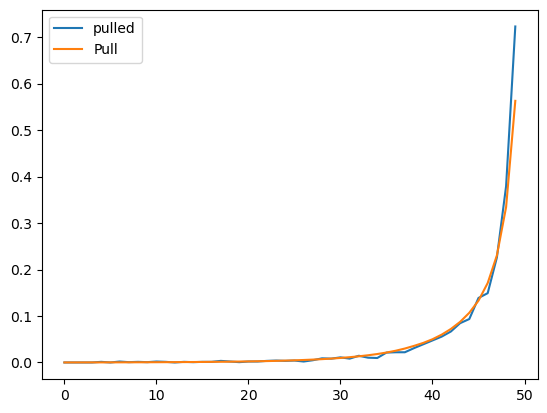

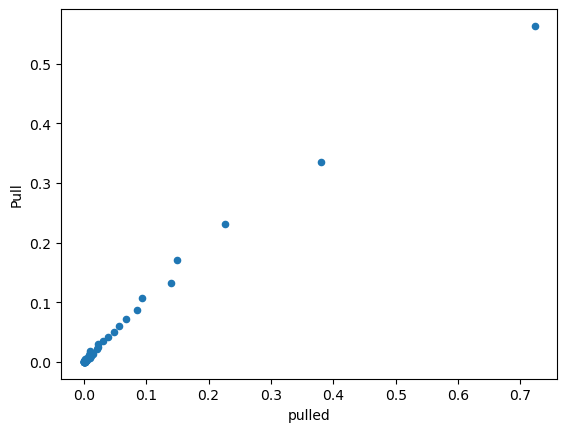

In [25]:
# Graph
long['decile'] = pd.qcut(long['Pull'], 50, labels=False)
long_graph = long.groupby('decile').mean().reset_index()

print(long_graph[['pulled', 'Pull']].plot.line())
print(long_graph.plot.scatter('pulled', 'Pull'))